# All the experiments have been run by using 128 worker nodes from Titan
# Each task correponds to the execution of an instance of AthenaMP for the simulation of 16 events of a collision within LHC
# All tasks have been cloned. Therefore,in principle, their execution times should be identical
# Each instance of AthenaMP runs on a single node and uses all its cores (16)

In [6]:
import extractData as ed
import plot as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy
fig_size =[10,6]
plt.rcParams["figure.figsize"] = fig_size

In [7]:

# Experiment file
outputFileName = "experiments-2017-07-06"
#Experiment folder
folderName = "exp-clean2"


In [8]:
## Collect data from a folder and put it in a single file
ed.collectData(outputFileName,folderName)

In [5]:
#Extract from outputFileName all the execution Times, the job number and the starting time. Group them by using the 
# RAM and Shared filesystem
ets = ed.readFileAndGroupBy(outputFileName,[4],[0,3,6],[True,True,True])

# Execution time as function of the job -- RAM disk vs Lustre



### We performed experiments by using both the RAM disk of the worker nodes and Lustre (Titan's shared filesystem). The two classes of experiments have been alternated in order to find the system in the same state with high probability. 

### The plot below shows how the experiments that used the Shared filesystem are characterized by higher execution times than those that used the RAM disk.   


## BEFORE CONTINUING -- Note that:
   
   - in the second block of experiments the wall-time of the tasks using using Lustre have been extended from 1 hour to 2 hours 

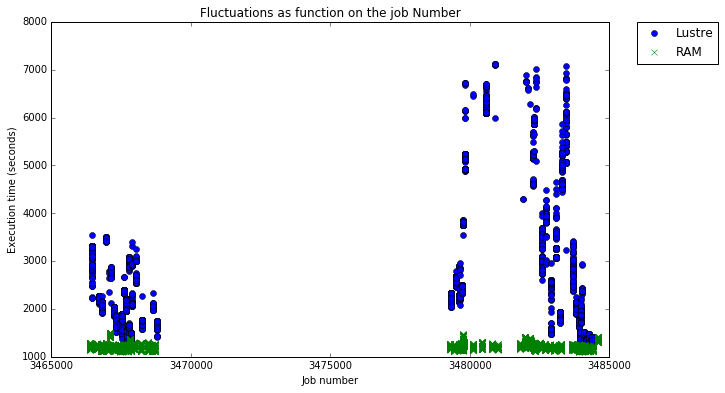

In [6]:
lustre, = plt.plot(ets['Shared'][0],ets['Shared'][2],label="Lustre",marker="o",linestyle="")
RAMDisk, = plt.plot(ets['RAM'][0],ets['RAM'][2], "x",label="RAM")
plt.legend(handles=[lustre,RAMDisk],numpoints=1,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Fluctuations as function on the job Number")
plt.ylabel("Execution time (seconds)")
plt.xlabel("Job number")
mpl.rcParams["figure.figsize"] = fig_size
plt.show()

# Distribution of the execution time -- RAM disk against Lustre

## The plot below provide a comparison of the distribution of the execution times of the tasks that used the RAM disk against those the used Lustre

### We notice that, for the experiments that used the RAM disk, the support of the distribution is compact and ranges between 1100 and 1500 seconds.

### The distribution of the execution times of the tasks that used Lustre is instead long-tailed and ranges between 1100 and 7000.





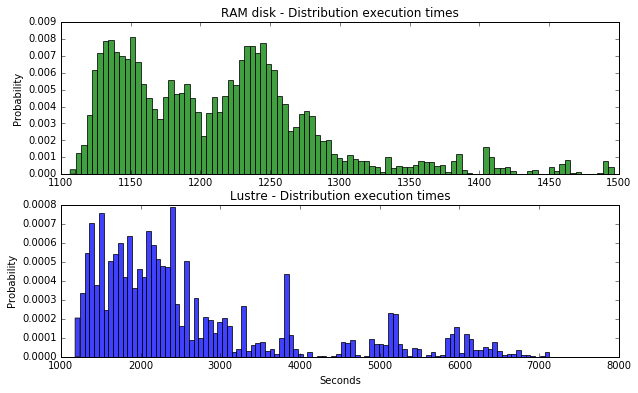

In [7]:
plt.close('all')

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2)

axarr[0].hist(ets['RAM'][2], 100, normed=1, facecolor='green', alpha=0.75)

axarr[0].set_title('RAM disk - Distribution execution times')
axarr[0].set_ylabel("Probability")
axarr[0].set_xlabel("")
axarr[1].hist(ets['Shared'][2], 100, normed=1, facecolor='blue', alpha=0.75)
axarr[1].set_title('Lustre - Distribution execution times')

axarr[1].set_ylabel("Probability")
axarr[1].set_xlabel("Seconds")
plt.show()


# Control of the spawning ---  Tasks as function of the starting time 

## The plot shows that the alignment of the tasks does not change if we consider the starting time of each tasks instead of the job number (the differences between the plot above and the plot below are barely visibile). Therefore tasks within a job can be assumed as started all together (No significant differences have been found).


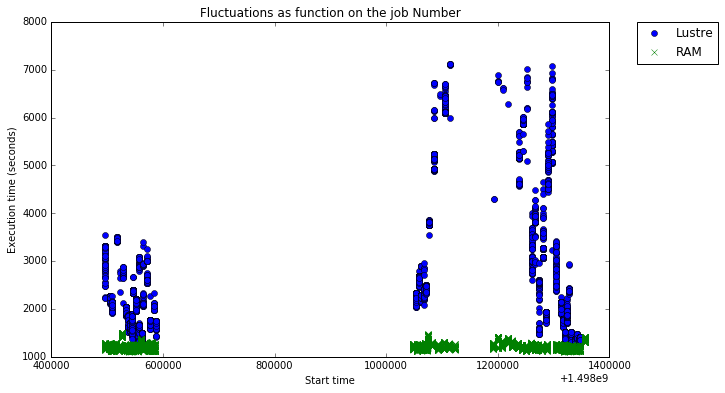

In [145]:
lustre, = plt.plot(ets['Shared'][1],ets['Shared'][2],label="Lustre",marker="o",linestyle="")
RAMDisk, = plt.plot(ets['RAM'][1],ets['RAM'][2], "x",label="RAM")
plt.legend(handles=[lustre,RAMDisk],numpoints=1,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Fluctuations as function on the job Number")
plt.ylabel("Execution time (seconds)")
plt.xlabel("Start time")
plt.show()




# Execution time as function of the worker node



## 1) We this plot we want to investigate if the fluctuations are consequence of the node that execute the tasks. For this reason we isolated those worker nodes that have executed more than five tasks and created a scatter plot of the execution times as function of the worker nodes. 

### The plot shows that fluctuations are independent from the nodes. In fact, each node shows a similar distribution of the execution times. It is actually astonishing how a high fluctuations at least one time in each of these nodes. 


## BEFORE CONTINUING ---  Note that:

- we decided to consider only the nodes that have executed at least five jobs in sake of readability but the same analysis can be performed with any number.
- Nodes indexes are relative not absolute

Initial number of nodes:4063
Reduced number of nodes:12


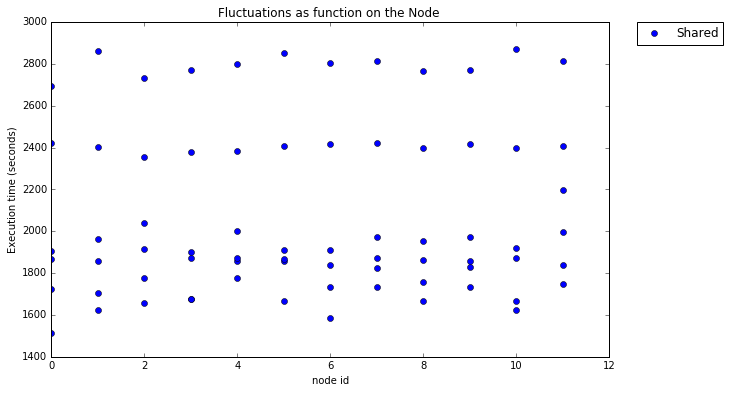

In [9]:
ets = ed.readFileAndGroupBy(outputFileName,[4,2],[6],[True])
# Clean all the table from all nodes that have not executed more than one job (they are not useful for comparison)
typeFileSystem = "Shared"
nodes = ets[typeFileSystem].keys()
print("Initial number of nodes:"+str(len(nodes)))
numTasks =5
#Reduce the keys to only those that have run more than one task
tempNodes = []
for x in nodes:
    if len(ets[typeFileSystem][x][0]) > numTasks:
        tempNodes.append(x)
nodes = tempNodes
print("Reduced number of nodes:"+str(len(nodes)))
#print(ets[typeFileSystem]['nid03756'][0])
#print(nodes)
#Creates a list that contains the index of the nodes
counter =0
x = []
#Creates a list of the execution times that follows the order of x
y = []

#Compute the first and second moment of the execution time for each node
m1 = []
m2 = []

for node in nodes:
    #Initialize the accumulator of the node
    m1.append(0)
    m2.append(0)
    #Initizialize counter2 --- #number of tasks per node
    cTasks= 0
    for item in ets[typeFileSystem][node][0]:
            #Append one index for each task that has been executed in node
            x.append(counter)
            #xnodes.append(node)
            y.append(item)
            #Add execution time 
            m1[counter]+=item
            #Add (execution time)^2
            m2[counter]+=item*item
            cTasks+=1
    #Compute first and second moment by divinding for the number of tasks
    m1[counter]/=cTasks
    m2[counter]/=cTasks
    #Compute variance --- FROM HERE m2[counter] is the variance and not the second moments
    m2[counter]-= m1[counter]*m1[counter]
    #Compute standard deviation -- FROM HERE m2[counter] is the standard deviation --- TODO : use a temporary variable to avoid inconsistences
    m2[counter]= numpy.sqrt(m2[counter])

    counter+=1
    
splot, = plt.plot(x,y,label=typeFileSystem,marker="o",linestyle="")
#plt.xticks(x,xnodes,rotation='vertical')
plt.legend(handles=[splot],numpoints=1,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Fluctuations as function on the Node ")
plt.ylabel("Execution time (seconds)")
plt.xlabel("node id")
plt.show()

# 2) Average and standard deviation per node

### In order to give a better representation of the independence from the nodes, we provide a plot depicting the average execution time of on the nodes that ran more than five tasks. Error bars represent the standard deviation of the execution times.

### We can observe that all the nodes have comparable averages and standard deviation. Therefore, nodes are not responsible for the fluctuations.

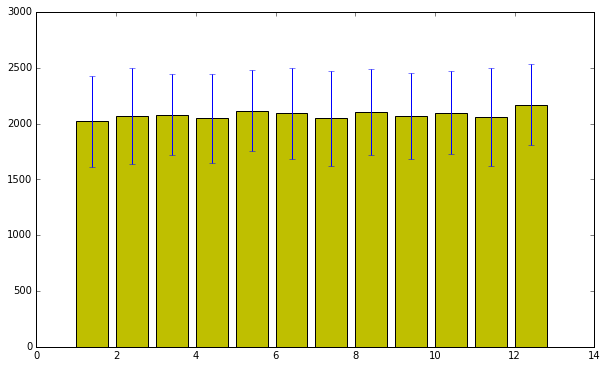

In [10]:
#Create indexes for nodes
xnodes = numpy.linspace(1,len(nodes),len(nodes))
rects2 = plt.bar(xnodes, m1,yerr=m2, color='y')
plt.show()

In [11]:

'''
The method counts how many jobs have not finished all the tasks by checking the length of each lists.
'''
def countAbortedJobs(numJobs,experiments):
    counter=0
    for key in experiments:
        if len(experiments[key][0]) < numJobs:
            counter+=1
    return counter


# Job aborted because they hit the wall time

## The bar chart shows the overall number of executed jobs and compares it with the number of jobs that have been aborted by the scheduler before finishing all the tasks.

### We observe that none of the jobs that used the RAM disks have been aborted.

### All the jobs that executed tasks on the filesystem have 


## The experiments tha used Shared filesystem with a walltime of an hour were 22. Six of them hit the walltime


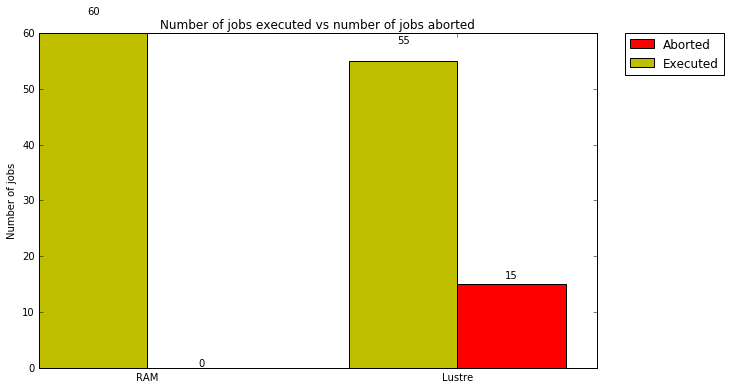

In [13]:



#Extract Execution times from a file an group them in a hiearchy that has the filesystem at the first level 
#and the job names at the second
ets = ed.readFileAndGroupBy(outputFileName,[4,0],[6],[True])
# Count aborted jobs for RAM disk
countRAM = countAbortedJobs(128,ets['RAM'])
# Count aborted jobs for Shared filesystem
countShared = countAbortedJobs(128,ets['Shared'])
# Total number of jobs executed on RAM disk
totRAM = len(ets['RAM'])
# Total number of jobs executed on Shared disk
totShared = len(ets['Shared'])


aborted = [countRAM,countShared]
total = [totRAM,totShared]

ind = numpy.arange(2)  # the x locations for the groups
width = 0.35       # the width of the bars

rects1 = plt.bar(ind + width, aborted, width, color='r')

rects2 = plt.bar(ind, total, width, color='y')


# add some text for labels, title and axes ticks
plt.ylabel('Number of jobs')
plt.title('Number of jobs executed vs number of jobs aborted')
plt.xticks(ind + width,["RAM","Lustre"])
#plt.xticklabels(('RAM', 'Lustre'))
plt.legend()

plt.legend((rects1[0], rects2[0]), ('Aborted','Executed'),numpoints=1,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.show()